In [38]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [39]:
# Load the dataset from CSV file

df = pd.read_csv("data\job_app_confirmation_emails_anonymized.csv")

# data clean

df.rename(columns={
    'Unnamed: 0': 'id',
    'email_body': 'body'
}, inplace=True)

# droppint the redundant index colum if exists after renaming

if 'id' in df.columns:
    df.set_index('id', inplace=True)
    
print("Log: Columns renamed and index set.")
print(f"Log: Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

Log: Columns renamed and index set.
Log: Dataset loaded with 657 rows and 11 columns.


C:\Users\AMAN\AppData\Local\Temp\ipykernel_23476\2926421021.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_senders.values, y=top_senders.index, palette='crest')


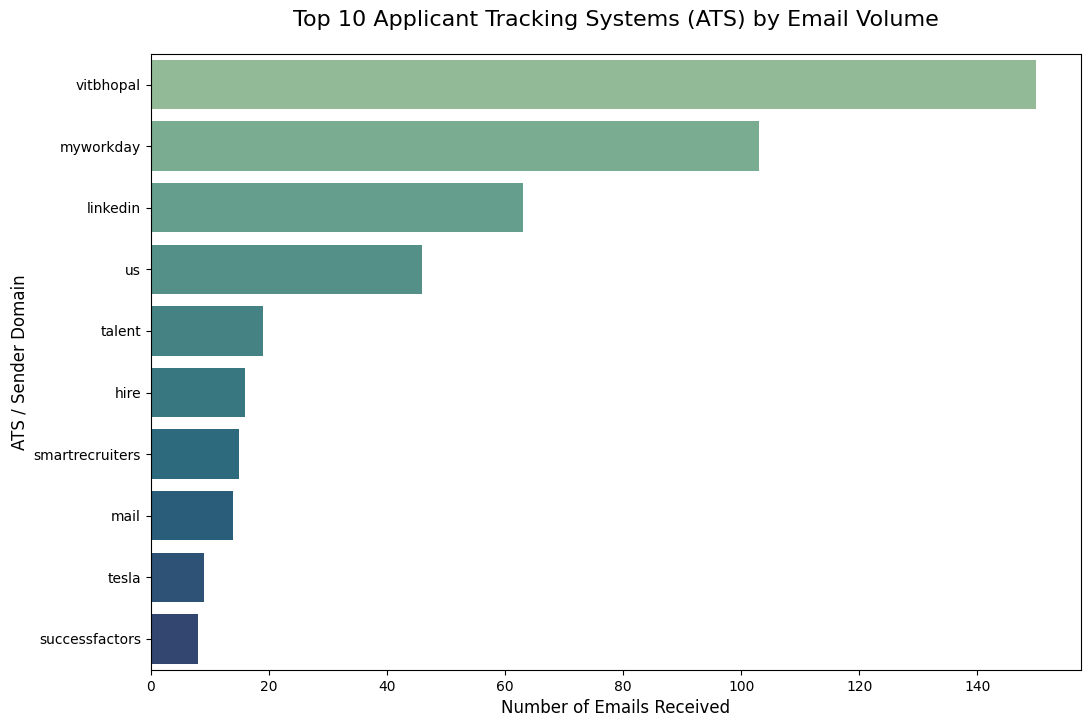

In [51]:
# --- Visualize Top Senders ---
plt.figure(figsize=(12, 8))
# Clean up sender names for better grouping (e.g., group all Workday or Greenhouse emails)
df['sender_domain'] = df['sender'].apply(lambda x: x.split('@')[-1].replace('>', '').split('.')[0] if isinstance(x, str) else 'unknown')
top_senders = df['sender_domain'].value_counts().nlargest(10)

sns.barplot(x=top_senders.values, y=top_senders.index, palette='crest')
plt.title('Top 10 Applicant Tracking Systems (ATS) by Email Volume', fontsize=16, pad=20)
plt.xlabel('Number of Emails Received', fontsize=12)
plt.ylabel('ATS / Sender Domain', fontsize=12)
plt.show()


p2

---

Log: Advanced application status classification complete.
Log: Counts per new status:
 application_status
Applied            362
General            166
Rejection           70
Action Required     53
Offer                6
Name: count, dtype: int64


C:\Users\AMAN\AppData\Local\Temp\ipykernel_23476\3610446271.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')


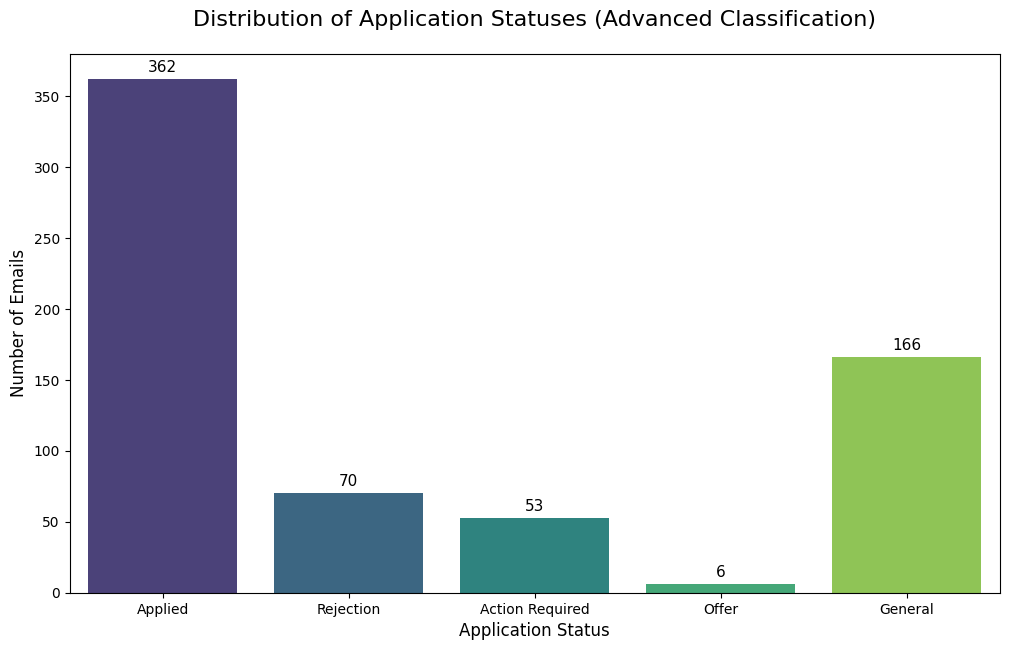

In [52]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

def classify_email_status_advanced(row):
    """
    Performs a "god-level" classification of recruitment emails using a hierarchical,
    multi-layered keyword and regex approach for maximum accuracy.
    
    The logic is tiered to prevent misclassification:
    1.  Check for an Offer.
    2.  Check for a Rejection.
    3.  Check for an Action/Interview request.
    4.  Check for a simple Application Confirmation.
    5.  If none of the above, classify as General.
    """
    text = (str(row['subject']) + ' ' + str(row['body'])).lower()

    # --- Tier 1: Offer of Employment (Highest Priority) ---
    offer_keywords = [
        'offer of employment', 'job offer', 'extend an offer', 'congratulations on the offer',
        'offer letter', 'welcome to the team', 'official offer', 'compensation package',
        'your new role', 'background check' # Often precedes a formal offer
    ]
    if any(keyword in text for keyword in offer_keywords):
        return 'Offer'

    # --- Tier 2: Rejection (High Priority) ---
    # These keywords definitively end the application process for this role.
    rejection_keywords = [
        'not moving forward', 'will not be proceeding', 'not be proceeding', 'decided to move forward with other',
        'pursue other candidates', 'pursue other applicants', 'other applicants whose skills',
        'position has been filled', 'no longer under consideration', 'no longer in the running',
        'not selected for this role', 'application was unsuccessful', 'not a fit at this time',
        'do not have an immediate opening', 'filled the position', 'wish you the best of luck',
        'encourage you to apply for future', 'application has been archived', 'no longer available',
        'after careful consideration', 'regret to inform you', 'difficult decision',
        'weren\'t the right fit', 'will not be advancing', 'thank you for your interest, but',
        'position is no longer open', 'we have selected another candidate'
    ]
    if any(keyword in text for keyword in rejection_keywords):
        return 'Rejection'

    # --- Tier 3: Action Required / Interview (High Engagement Signal) ---
    # These require the applicant to do something.
    action_keywords = [
        'action required', 'next steps', 'next stage', 'next round', 'interview availability',
        'schedule an interview', 'invitation to interview', 'select a time to connect',
        'phone screen', 'phone interview', 'video interview', 'technical interview', 'on-site',
        'coding assessment', 'coding challenge', 'technical test', 'hackerrank', 'codility', 'leetcode',
        'take-home assignment', 'assessment', 'complete your application', 'provide more information',
        'confirm your interest', 'self-schedule', 'next step in the process', 'what to expect',
        'we would like to speak with you', 'request to interview', 'interview schedule', 'online assessment',
        'game-based assessment', 'your availability for an interview'
    ]
    if any(keyword in text for keyword in action_keywords):
        # This logic prevents a simple "application" confirmation from being marked as "Action Required"
        if not ('your application was sent' in text or 'thank you for applying' in text):
             return 'Action Required'

    # --- Tier 4: Application Received / Confirmation (Standard Confirmation) ---
    # These are general "we got it" emails with no immediate action.
    confirmation_keywords = [
        'thank you for applying', 'application received', 'we have received your application',
        'your application has been received', 'application has been submitted', 'we’ve received your application',
        'application is under review', 'successfully submitted', 'confirming your application',
        'your application was sent to', 'thanks for applying', 'submission confirmation',
        'your application for the', 'thank you for your interest'
    ]
    if any(keyword in text for keyword in confirmation_keywords):
        return 'Applied'

    # --- Tier 5: General / Informational (Lowest Priority) ---
    # If none of the above specific categories match, it's likely a general update or newsletter.
    return 'General'

# Apply the new, advanced classification function
df['application_status'] = df.apply(classify_email_status_advanced, axis=1)

print("Log: Advanced application status classification complete.")
status_counts = df['application_status'].value_counts()
print("Log: Counts per new status:\n", status_counts)

# --- Visualize the New, More Accurate Classification Results ---
plt.figure(figsize=(12, 7))
status_order = ['Applied', 'Rejection', 'Action Required', 'Offer', 'General']
# Reindex to ensure consistent order in the plot
status_counts = status_counts.reindex(status_order, fill_value=0)

sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title('Distribution of Application Statuses (Advanced Classification)', fontsize=16, pad=20)
plt.ylabel('Number of Emails', fontsize=12)
plt.xlabel('Application Status', fontsize=12)
for i, count in enumerate(status_counts.values):
    plt.text(i, count + 5, str(count), ha='center', fontsize=11)
plt.show()
